In [93]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from autocorrect import Speller #autocorrector
from bertopic import BERTopic

In [94]:
import umap
import seaborn as sns
import numpy as np
import pandas as pd
import re
import itertools

## Lectura del dataset "app_reviews"

In [95]:
review = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
review

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,4
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,4
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,5
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,3
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,5
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,3
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,5
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,5
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,5


## Limpieza del dataset 

### Se extrae en un corpus todos los reviews o criticas de usuario

In [96]:
def extract_corpus(dataset):
    lista = []  
    for i in range(len(dataset['package_name'].unique())):
        dataset_temp = dataset.loc[dataset['package_name'] == dataset['package_name'].unique()[i]]
        lista.append({'package_name':dataset['package_name'].unique()[i], 'size': len(dataset_temp)})

    lista = sorted(lista, key=lambda x: x['size'], reverse=True)
    dataframe = dataset[dataset['package_name'] == lista[300]['package_name']]
    corpus = list(dataframe['review'])
    
    #corpus = clean_corpus(corpus)

    return corpus

### Se crea una función que nos permita incrustar las oraciones, para esto usamos un modelo pre-entrenado de SBERT

In [97]:
def neural_embeddings(corpus):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')

    embeddings = model_embedder.encode(corpus, convert_to_tensor=True, show_progress_bar=True)
    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)

    return embeddings

### Para dar visualización de estas oraciones en un plano euclidiano, aplicamos una técnica de reducción de dimensiones 

In [98]:
def dimension_reduction(embeddings):
    scaler = umap.UMAP(n_components=2).fit_transform(embeddings)
    dimension_2d = pd.DataFrame(scaler, columns=['x', 'y'])
    return dimension_2d

### Para obtener el "mejor" cluster aplicamos el método de la silueta

In [99]:
def silhoutte(embeddings, attempts):

    scores_silhouette = []

    for k in range(2,attempts):

        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, affinity="cosine" , linkage="complete").fit(embeddings)
        cluster_labels = agglomerative_clusterering.labels_

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        scores_silhouette.append(silhouette_avg)

    max_score = max(scores_silhouette)
    max_index = scores_silhouette.index(max_score)
    n_clusters = max_index + 2

    return n_clusters

### Al tener el "mejor" número de clusters, se procede a segmentar las oraciones

In [100]:
def segmentation(n_clusters, embeddings):
    agglomerative_clusterering = AgglomerativeClustering(n_clusters=5, affinity="cosine" , linkage="complete").fit(embeddings)
    cluster_labels = agglomerative_clusterering.labels_

    return cluster_labels

In [101]:
def topics_labels(n_clusters, corpus):
    model = BERTopic(nr_topics = 5).fit(corpus)
    labels = model.generate_topic_labels()
    labels.pop(0)
    print(labels)
    return labels 

In [102]:
def convert_corpus_to_dataFrame(corpus):
    corpus_ds = {
        'Sentences' : corpus
    }

    dataset_new = pd.DataFrame(corpus_ds)
    return dataset_new

### A cada oración le asignamos el cluster al que pertenece

In [103]:
def clustering(labels, corpus):    
    corpus_dataframe = convert_corpus_to_dataFrame(corpus)
    corpus_dataframe['cluster'] = labels

    return corpus_dataframe

In [105]:
corpus = extract_corpus(review)
embeddings = neural_embeddings(corpus)
best_cluster = silhoutte(embeddings, 5)
labels_cluster = segmentation(best_cluster, embeddings)
topics_labels = topics_labels(best_cluster, corpus)
dataframe_review_segment = clustering(labels_cluster,corpus)

topics = []
for i in dataframe_review_segment['cluster']:
    topics.append(topics_labels[i])

dataframe_review_segment['Topics'] = topics
dataframe_review_segment

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[3 0 1 0 0 2 3 3 3 0 0 2 1 0 0 0 1 4 0 0 1 0 2 0 1 3 0 2 2 0]


TypeError: 'list' object is not callable

### Mostraremos un gráfico de la segmentación de oraciones y un DataFrame de las oraciones con su respectivo cluster 

In [ ]:
def show_graphics_and_themes(dataset_review, attemps):

    labels_HAC, embeddings, segment_review = clustering(dataset_review, attemps)
    print(segment_review)
    review_2d = dimension_reduction(embeddings)

    review_2d['labels'] = labels_HAC
    
    plt.figure(figsize=(14, 8))
    clustered = review_2d[review_2d.labels != -1]
    plt.scatter(review_2d.x, review_2d.y, c=clustered.labels, s=20, cmap='Spectral')
    plt.colorbar()
    plt.show()

    return segment_review

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

                                            Sentences  cluster
0   Great! Running Android 6 and your app cannot f...        2
1   Doesn't search SD card Will only search for fi...        0
2   Just what I needed It is fast and easy to use....        3
3    Enjoying this app. Searching txt files made easy        0
4   Not intuitive at all Just try to select the ta...        5
5                               Perfect! meet my need        1
6                ? Doesn't work. For my phone anyway.        8
7                                           No works.        8
8   Not working I can no longer add folders to sea...        2
9   I used the app to search for names in a direct...        0
10  Very fast  very useful for me. I'm using a lot...        0
11                   great workz exactly as described        1
12  Thank you Thank you for such great application...        7
13  Works just as I expected! I searched for 'sear...        0
14      great finds files with words i am looking for  

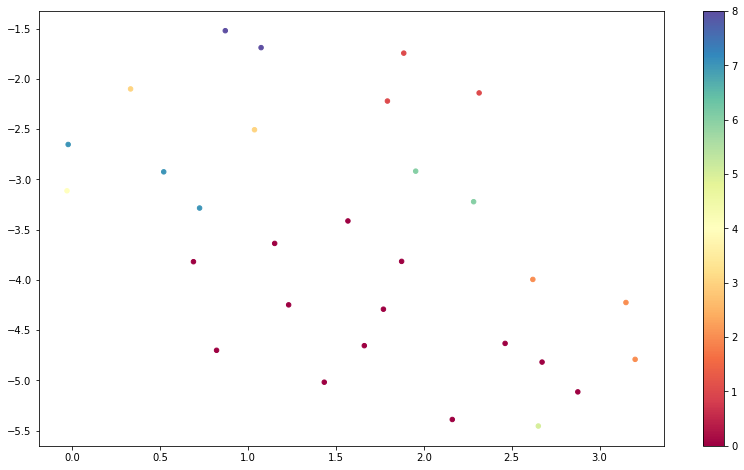

                                            Sentences  cluster
0   Great! Running Android 6 and your app cannot f...        2
1   Doesn't search SD card Will only search for fi...        0
2   Just what I needed It is fast and easy to use....        3
3    Enjoying this app. Searching txt files made easy        0
4   Not intuitive at all Just try to select the ta...        5
5                               Perfect! meet my need        1
6                ? Doesn't work. For my phone anyway.        8
7                                           No works.        8
8   Not working I can no longer add folders to sea...        2
9   I used the app to search for names in a direct...        0
10  Very fast  very useful for me. I'm using a lot...        0
11                   great workz exactly as described        1
12  Thank you Thank you for such great application...        7
13  Works just as I expected! I searched for 'sear...        0
14      great finds files with words i am looking for  

In [ ]:
print(show_graphics_and_themes(review, 10))

In [ ]:
def show_dimentions(distribution):
    for col in 'xy':
        sns.kdeplot(distribution[col], shade=True)

    with sns.axes_style(style='ticks'):
       g = sns.factorplot(data=distribution, kind="box")